### Optical Heterodyne Detection

At Receiver (Rx) side, Phase Modulated Optical signal is mixed with local oscillator.

In the case of optical heterodyne,mmixer is either Beam Splitter or fused fiber coupler.

Both are identical in terms of optics.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.constants import c

In [12]:
def propagate(phase1, phase2, Ein=np.array([[1],[0]])):

    propagatematrix1 = np.array([[np.exp(1j*phase1),0],[0,np.exp(1j*phase2)]]);

    Eout = np.dot(propagatematrix1,Ein)
    
    return Eout


def beamsplitter(PT,Ein):

   # See Wikipedia for details. https://en.wikipedia.org/wiki/Beam_splitter       

   # Dielectric type Beam Splitter
     #phiT = 0
     #phiR = 0
     #phiO = 0

   # Symmetric type Beam Splitter
     phiT = 0
     phiR = -0.5 * np.pi    
     phiO = 0.5 * np.pi
     
     T = np.sqrt(PT) # Transmission defined as Electric field

     PR = 1-PT 

     R = np.sqrt(PR) # Reflection defined as Electric field

     Theta1 = np.arctan(R/T) # Split Raio in Radian   
         
     BSmatrix1 = np.dot(np.exp(1J*phiO),np.array([[np.sin(Theta1)*np.exp(1J*phiR),np.cos(Theta1)*np.exp(-1J*phiT)],[np.cos(Theta1)*np.exp(1j*phiT),-1*np.sin(Theta1)*np.exp(-1J*phiR)]]))
     
     Eout = np.dot(BSmatrix1, Ein)

     return Eout

Light Frequency1: lightfreq1 [Hz]
1.93414E+14

Light Frequency2: lightfreq2 [Hz]
1.93414E+14

Difference Frequency: freq_diff [Hz]
0.00000E+00



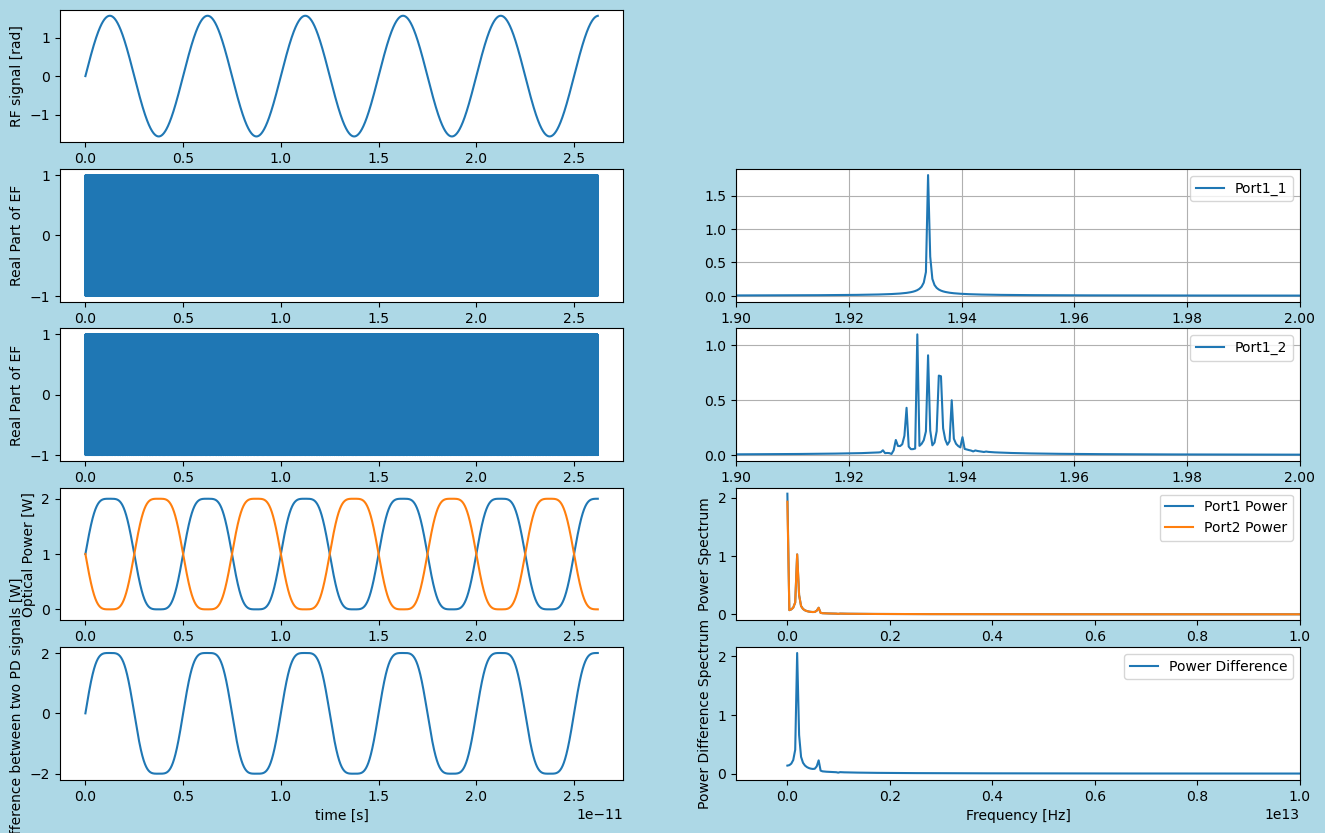

In [13]:
samplerate = 2**16 # Number of Points
t_step = 4 * 1e-16 #[s]

tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

amp_c = 0.5 * np.pi
#amp_c = 0
freq_rf = 200e9 # [Hz]

md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

no = 1 # Refractive Index of medium

wl1 = 1550e-9 
wl2 = 1550e-9

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

opl1 =100 
opl2= 100


# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

lightfreq1 = c / wl1
print("Light Frequency1: lightfreq1 [Hz]")
print(f'{lightfreq1:.5E}')
print("")

lightfreq2 = c / wl2
print("Light Frequency2: lightfreq2 [Hz]")
print(f'{lightfreq2:.5E}')
print("")

freq_diff = lightfreq1-lightfreq2

print("Difference Frequency: freq_diff [Hz]")
print(f'{freq_diff:.5E}')
print("")

PT1 = 0.5 # PT: Power Transmission of Beam splitter

# Define Input Electric Field: Both 1 and 2 port

#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

#tcol = np.zeros(samplerate)
rfsignalcol = np.zeros(samplerate)
Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_EFcol = np.zeros(samplerate,dtype=complex)
Port3_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_powercol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)
Power_diffcol = np.zeros(samplerate)

for ii in range(samplerate):
    
    t = tcol[ii]

    rf_signal = amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    rfsignalcol[ii] = rf_signal  
    
    # Path Length modulated

    phase1 = 2*np.pi * lightfreq1 * t # phase of local oscillator [rad]
    
    #phase2 = 2*np.pi * lightfreq2 * t # Phase of Continious Wave [rad]
    phase2 = 2*np.pi * lightfreq2 * t + rf_signal # Phase of Modulated Light [rad]

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Power Difference
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (16,10), facecolor='lightblue')

ax1_1 = fig1.add_subplot(5, 2, 1)
ax1_3 = fig1.add_subplot(5, 2, 3)
ax1_5 = fig1.add_subplot(5, 2, 5)
ax1_7 = fig1.add_subplot(5, 2, 7)
ax1_9 = fig1.add_subplot(5, 2, 9)

ax1_4 = fig1.add_subplot(5, 2, 4)
ax1_6 = fig1.add_subplot(5, 2, 6)
ax1_8 = fig1.add_subplot(5, 2, 8)
ax1_10 = fig1.add_subplot(5, 2, 10)


ax1_1.plot(tcol,rfsignalcol)
ax1_1.set_ylabel("RF signal [rad]")


ax1_3.plot(tcol,np.real(Port1_1_EFcol))
ax1_3.set_ylabel("Real Part of EF")

ax1_5.plot(tcol,np.real(Port1_2_EFcol))
ax1_5.set_ylabel("Real Part of EF")

ax1_7.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax1_7.set_ylabel("Optical Power [W]")
ax1_7.set_ylim(-0.2,2.2)

ax1_9.plot(tcol,Power_diffcol)
ax1_9.set_xlabel("time [s]")
ax1_9.set_ylabel("Difference between two PD signals [W]")


xf = fftfreq(samplerate, t_step)[:samplerate//2]

Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

ax1_4.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax1_4.set_xlim(190e12,200e12)
ax1_4.legend()
ax1_4.grid(True)

ax1_6.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax1_6.set_xlim(190e12,200e12)
ax1_6.legend()
ax1_6.grid(True)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax1_8.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax1_8.set_ylabel("Power Spectrum")
ax1_8.set_xlim(-1e12,10e12)
ax1_8.legend()


ax1_8.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax1_8.set_ylabel("Power Spectrum")
ax1_8.set_xlim(-1e12,10e12)
ax1_8.legend()


Power_diffcol_f = fft(Power_diffcol)
ax1_10.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax1_10.set_xlabel("Frequency [Hz]")
ax1_10.set_ylabel("Power Difference Spectrum")
ax1_10.set_xlim(-1e12,10e12)
ax1_10.legend()
plt.show()

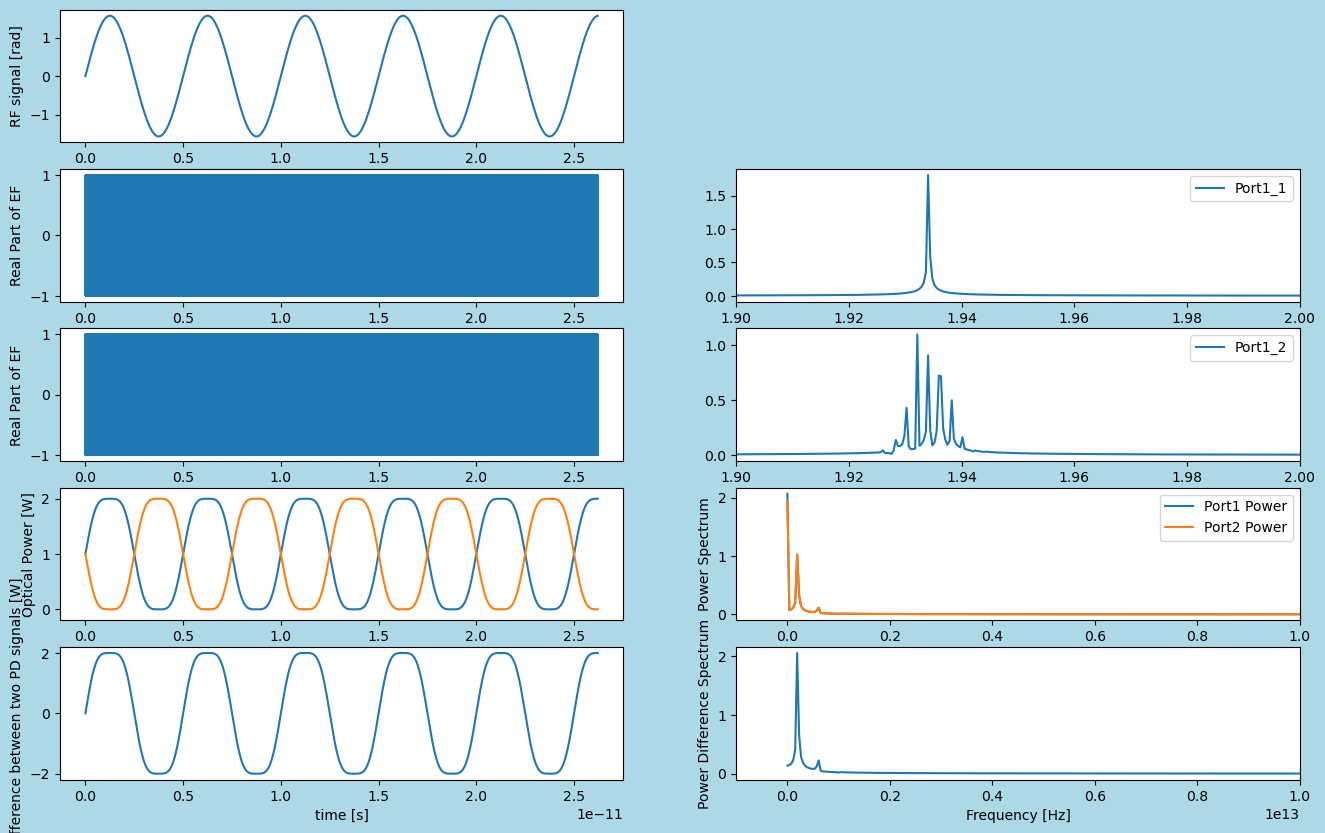

In [14]:
fig111 = plt.figure(figsize = (16,10), facecolor='lightblue')

ax111_1 = fig111.add_subplot(5, 2, 1)
ax111_3 = fig111.add_subplot(5, 2, 3)
ax111_5 = fig111.add_subplot(5, 2, 5)
ax111_7 = fig111.add_subplot(5, 2, 7)
ax111_9 = fig111.add_subplot(5, 2, 9)

ax111_4 = fig111.add_subplot(5, 2, 4)
ax111_6 = fig111.add_subplot(5, 2, 6)
ax111_8 = fig111.add_subplot(5, 2, 8)
ax111_10 = fig111.add_subplot(5, 2, 10)


ax111_1.plot(tcol,rfsignalcol)
ax111_1.set_ylabel("RF signal [rad]")

ax111_3.plot(tcol,np.real(Port1_1_EFcol))
ax111_3.set_ylabel("Real Part of EF")

ax111_5.plot(tcol,np.real(Port1_2_EFcol))
ax111_5.set_ylabel("Real Part of EF")

ax111_7.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax111_7.set_ylabel("Optical Power [W]")
ax111_7.set_ylim(-0.2,2.2)

ax111_9.plot(tcol,Power_diffcol)
ax111_9.set_xlabel("time [s]")
ax111_9.set_ylabel("Difference between two PD signals [W]")


ax111_4.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax111_4.set_xlim(190e12,200e12)
ax111_4.legend()


ax111_6.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax111_6.set_xlim(190e12,200e12)
ax111_6.legend()

ax111_8.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax111_8.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax111_8.set_ylabel("Power Spectrum")
ax111_8.set_xlim(-1e12,10e12)
ax111_8.legend()


ax111_10.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax111_10.set_xlabel("Frequency [Hz]")
ax111_10.set_ylabel("Power Difference Spectrum")
ax111_10.set_xlim(-1e12,10e12)

plt.savefig(f"{wl2}_{freq_rf}.png", dpi=300)

plt.show()



### Rectangular Pulse

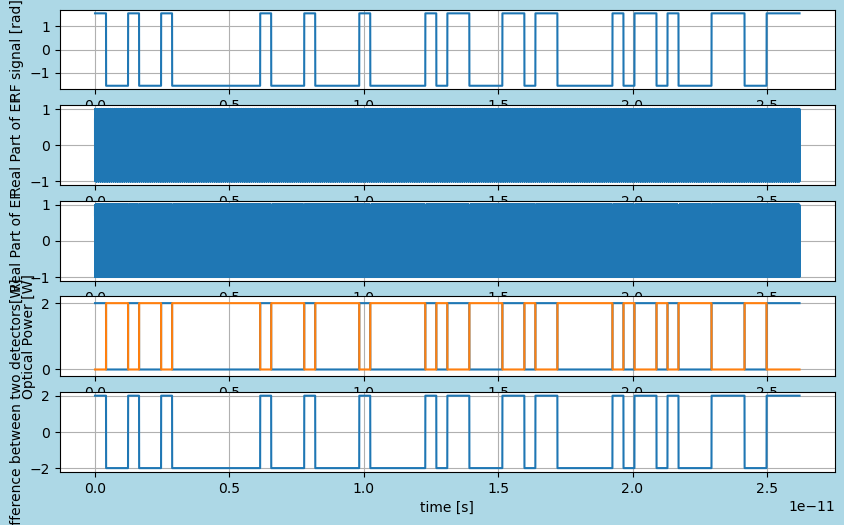

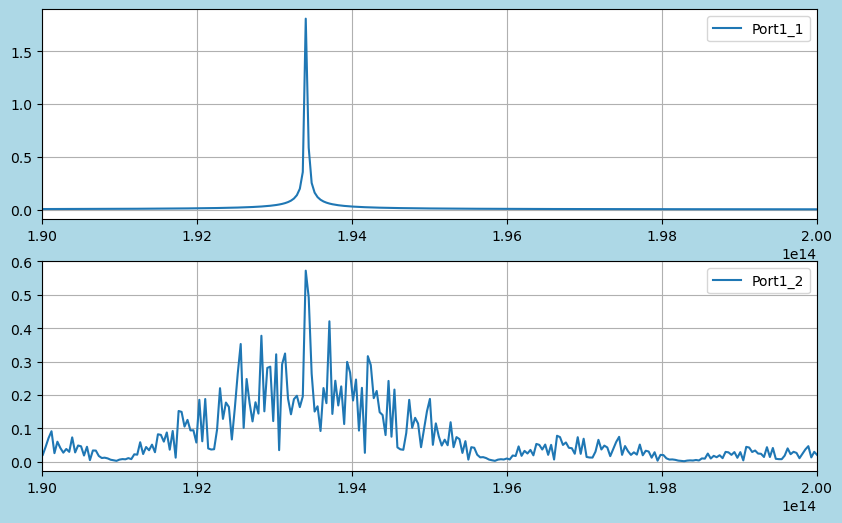

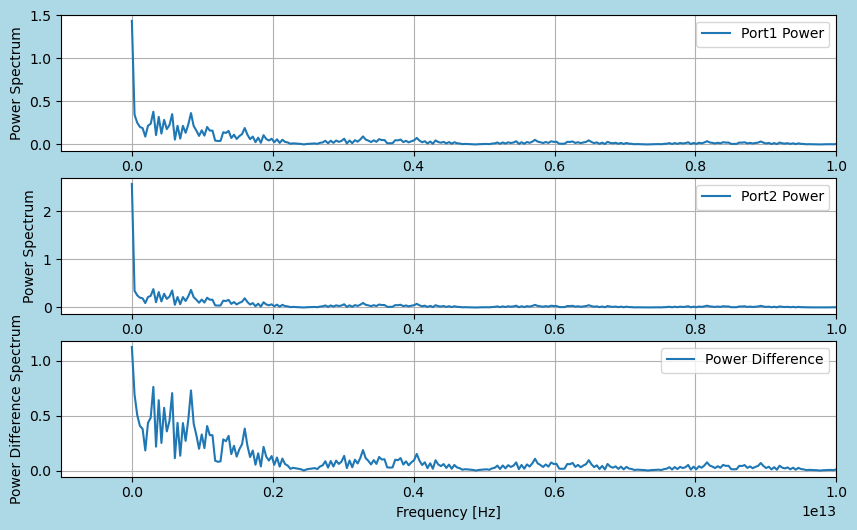

In [15]:
from prbs_def import prbs_1, prbs_2

#rfsignalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50])
rfsignalcol = prbs_2(samplerate, numberofpointspersymbol = 2 ** 6)

for ii in range(samplerate):
    
    t = tcol[ii]
    rfsignal = rfsignalcol[ii]
    
    #Phase Modulation. Path Length

    phase1 = 2*np.pi * lightfreq1 * t # phase of local oscillator [rad]
    phase2 = 2*np.pi * lightfreq2 * t + rfsignal #[rad]

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Diff
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1_1 = fig1.add_subplot(5, 1, 1)
ax1_2 = fig1.add_subplot(5, 1, 2)
ax1_3 = fig1.add_subplot(5, 1, 3)
ax1_4 = fig1.add_subplot(5, 1, 4)
ax1_5 = fig1.add_subplot(5, 1, 5)

ax1_1.plot(tcol,rfsignalcol)
ax1_1.set_ylabel("RF signal [rad]")
#ax1.set_ylim(-3.14,3.14)
ax1_1.grid()

ax1_2.plot(tcol,np.real(Port1_1_EFcol))
ax1_2.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax1_2.grid()

ax1_3.plot(tcol,np.real(Port1_2_EFcol))
ax1_3.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax1_3.grid()

ax1_4.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax1_4.set_ylabel("Optical Power [W]")
ax1_4.set_ylim(-0.2,2.2)
ax1_4.grid(True)

ax1_5.plot(tcol,Power_diffcol)
ax1_5.set_xlabel("time [s]")
ax1_5.set_ylabel("Power Difference between two detectors[W]")
ax1_5.grid()

xf = fftfreq(samplerate, t_step)[:samplerate//2]

Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_2 = fig2.add_subplot(2, 1, 2)

ax2_1.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax2_1.set_xlim(190e12,200e12)
ax2_1.legend()
ax2_1.grid(True)

ax2_2.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax2_2.set_xlim(190e12,200e12)
ax2_2.legend()
ax2_2.grid(True)

fig3 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_3 = fig3.add_subplot(3, 1, 3)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax3_1.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax3_1.set_ylabel("Power Spectrum")
ax3_1.set_xlim(-1e12,10e12)
ax3_1.legend()
ax3_1.grid(True)

ax3_2.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax3_2.set_ylabel("Power Spectrum")
ax3_2.set_xlim(-1e12,10e12)
ax3_2.legend()
ax3_2.grid(True)

Power_diffcol_f = fft(Power_diffcol)
ax3_3.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax3_3.set_xlabel("Frequency [Hz]")
ax3_3.set_ylabel("Power Difference Spectrum")
ax3_3.set_xlim(-1e12,10e12)
ax3_3.legend()
ax3_3.grid(True)

plt.show()

### PRBS: Pseudo Random Binary sequence

Light Frequency1: lightfreq1 [Hz]
1.93414E+14

Light Frequency2: lightfreq2 [Hz]
1.93414E+14

Difference Frequency: freq_diff [Hz]
0.00000E+00



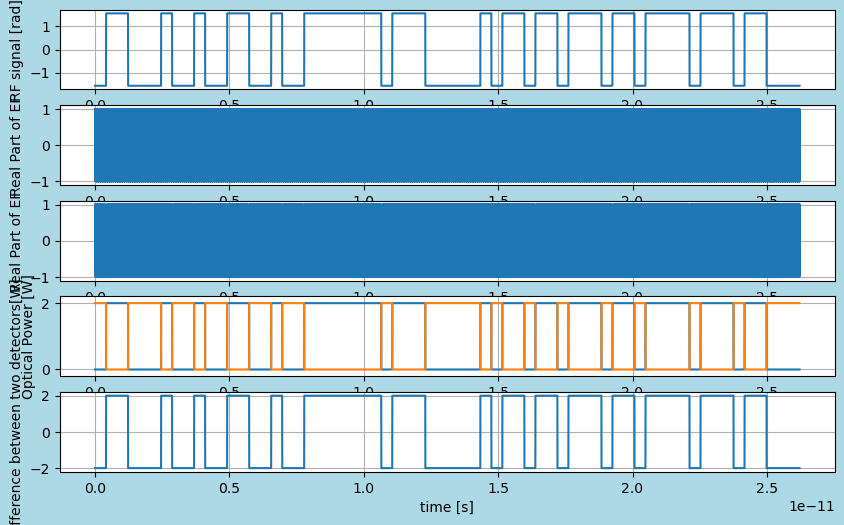

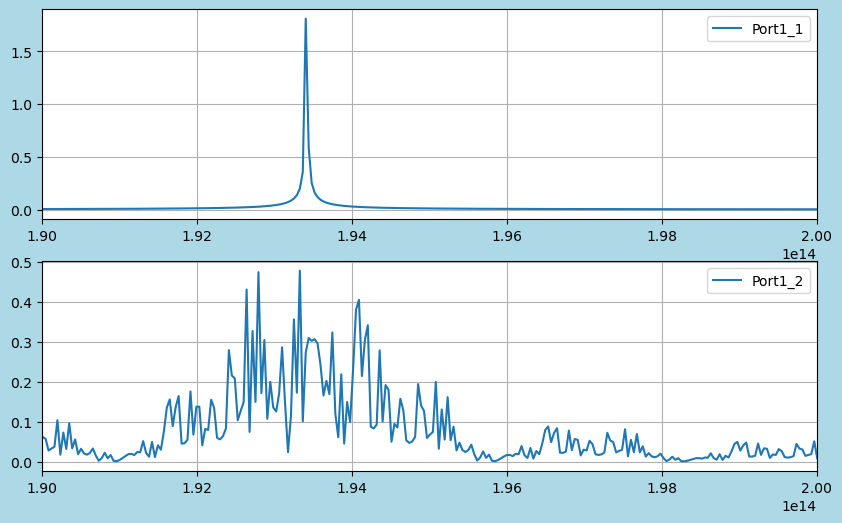

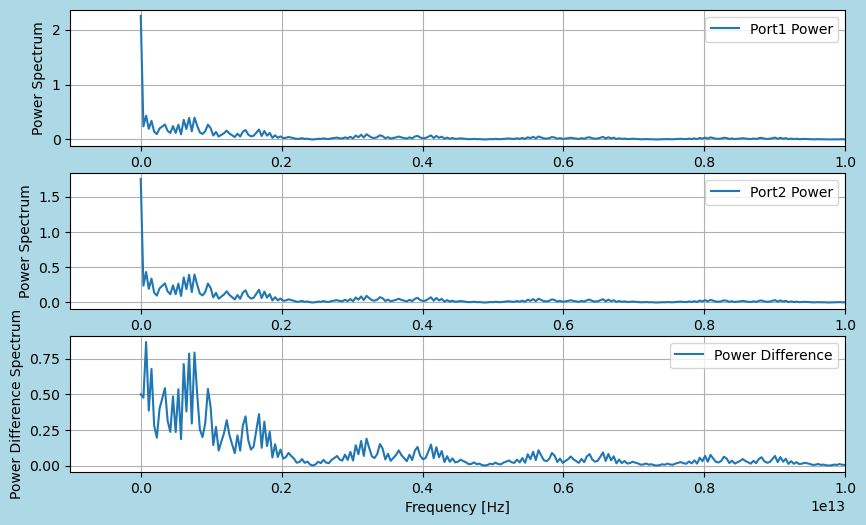

In [16]:

wl1 = 1550e-9 
wl2 = 1550e-9

# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

lightfreq1 = c / wl1
print("Light Frequency1: lightfreq1 [Hz]")
print(f'{lightfreq1:.5E}')
print("")

lightfreq2 = c / wl2
print("Light Frequency2: lightfreq2 [Hz]")
print(f'{lightfreq2:.5E}')
print("")

freq_diff = lightfreq1-lightfreq2

print("Difference Frequency: freq_diff [Hz]")
print(f'{freq_diff:.5E}')
print("")


from prbs_def import prbs_1, prbs_2

#rfsignalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50])
rfsignalcol = prbs_2(samplerate, numberofpointspersymbol = 2 ** 6)

for ii in range(samplerate):
    
    t = tcol[ii]
    rfsignal = rfsignalcol[ii]
    
    #Phase Modulation. Path Length

    phase1 = 2*np.pi * lightfreq1 * t # phase of local oscillator [rad]
    phase2 = 2*np.pi * lightfreq2 * t + rfsignal #[rad]

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Diff
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1_1 = fig1.add_subplot(5, 1, 1)
ax1_2 = fig1.add_subplot(5, 1, 2)
ax1_3 = fig1.add_subplot(5, 1, 3)
ax1_4 = fig1.add_subplot(5, 1, 4)
ax1_5 = fig1.add_subplot(5, 1, 5)

ax1_1.plot(tcol,rfsignalcol)
ax1_1.set_ylabel("RF signal [rad]")
#ax1.set_ylim(-3.14,3.14)
ax1_1.grid()

ax1_2.plot(tcol,np.real(Port1_1_EFcol))
ax1_2.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax1_2.grid()

ax1_3.plot(tcol,np.real(Port1_2_EFcol))
ax1_3.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax1_3.grid()

ax1_4.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax1_4.set_ylabel("Optical Power [W]")
ax1_4.set_ylim(-0.2,2.2)
ax1_4.grid(True)

ax1_5.plot(tcol,Power_diffcol)
ax1_5.set_xlabel("time [s]")
ax1_5.set_ylabel("Power Difference between two detectors[W]")
ax1_5.grid()

xf = fftfreq(samplerate, t_step)[:samplerate//2]

Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_2 = fig2.add_subplot(2, 1, 2)

ax2_1.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax2_1.set_xlim(190e12,200e12)
ax2_1.legend()
ax2_1.grid(True)

ax2_2.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax2_2.set_xlim(190e12,200e12)
ax2_2.legend()
ax2_2.grid(True)

fig3 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_3 = fig3.add_subplot(3, 1, 3)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax3_1.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax3_1.set_ylabel("Power Spectrum")
ax3_1.set_xlim(-1e12,10e12)
ax3_1.legend()
ax3_1.grid(True)

ax3_2.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax3_2.set_ylabel("Power Spectrum")
ax3_2.set_xlim(-1e12,10e12)
ax3_2.legend()
ax3_2.grid(True)

Power_diffcol_f = fft(Power_diffcol)
ax3_3.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax3_3.set_xlabel("Frequency [Hz]")
ax3_3.set_ylabel("Power Difference Spectrum")
ax3_3.set_xlim(-1e12,10e12)
ax3_3.legend()
ax3_3.grid(True)

plt.show()

### Summary

1. **Heterodyne Receiver**:
   - **Architecture**: In a heterodyne receiver, there are two main stages: the **mixer** and the **I/Q demodulator**.
   - **Signal Conversion**: The heterodyne receiver uses one mixer to convert the **modulated RF signal** to a **modulated intermediate frequency (IF)** signal. This modulated IF signal is then fed to the I/Q demodulator, which further converts it to the baseband signal at **zero IF**.
   - **Superheterodyne Receiver**: In the more common superheterodyne receiver, two mixers are employed. The first mixer shifts the RF signal to a **high IF**, and the second mixer brings the high IF signal down to a **low IF** before demodulation.
   - **Advantages**: Heterodyne receivers offer good selectivity and sensitivity.
   - **Challenges**: The superheterodyne design introduces complexity due to the need for multiple mixers and filters.

2. **Homodyne Receiver** (also known as **Direct Conversion Receiver**):
   - **Architecture**: The homodyne receiver does not require any mixers at the RF stage.
   - **Signal Conversion**: The modulated RF signal is directly applied to the I/Q demodulator, which provides baseband signals (I and Q) at **zero IF**.
   - **Phase Detection**: If the local oscillator (LO) frequency is synchronized in phase with the incoming carrier frequency signal, the receiver operates as a homodyne receiver.
   - **Advantages**: Homodyne receivers simplify the architecture by eliminating the need for multiple mixers. They also provide maximum information from the modulated I/Q signal using **quadrature down conversion**.
   - **Challenges**: The main issue in homodyne receivers is **LO leakage**, which must be minimized for efficient operation.
   - **Illustration**: The modulated signal is split into two channels and multiplied by sine and cosine functions. This results in a complex signal (I + jQ) with magnitude and phase information.
   - **Use Case**: Homodyne receivers are commonly used in modern communication systems.

In summary, heterodyne receivers involve frequency shifting, while homodyne receivers operate at the same frequency as the radiation to be detected. Both play crucial roles in radio technology, each with its own advantages and challenges¹²³. 📻.

Source: Conversation with Bing, 3/6/2024
(1) Heterodyne receiver vs Homodyne receiver-difference between .... https://www.rfwireless-world.com/Terminology/heterodyne-receiver-versus-homodyne-receiver.html.
(2) What is heterodyne and homodyne? - Studybuff.com. https://studybuff.com/what-is-heterodyne-and-homodyne/.
(3) Homodyne detection - Wikipedia. https://en.wikipedia.org/wiki/Homodyne_detection.
(4) homodyne and heterodyne.... | Forum for Electronics. https://www.edaboard.com/threads/homodyne-and-heterodyne.88222/.
(5) Heterodyne vs. Homodyne — What’s the Difference?. https://www.askdifference.com/heterodyne-vs-homodyne/.
(6) en.wikipedia.org. https://en.wikipedia.org/wiki/Heterodyne.